In [ ]:
Load Libraries

In [1]:
import scipy.io
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib as plt
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
import h5py

In [2]:
mat_contents = scipy.io.loadmat("/Users/haala/Downloads/s1 2/S1_A1_E1.mat")
emg_signals = mat_contents["emg"]
labels = np.array(mat_contents["restimulus"])
df = pd.DataFrame(emg_signals, columns=["col 1", "col 2", "col 3","col 4", "col 5", "col 6","col 7", "col 8", "col 9","col 10"])



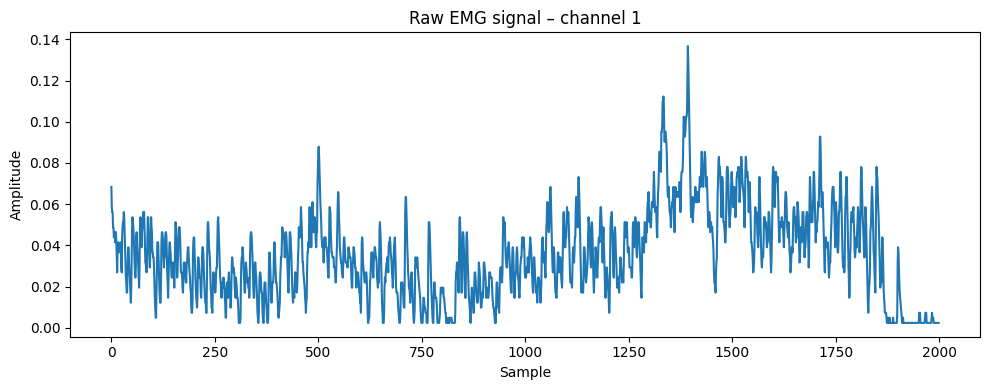

In [11]:
import matplotlib.pyplot as plt  # or move your matplotlib import here and change to pyplot

plt.figure(figsize=(10, 4))
plt.plot(df["col 1"][:2000])
plt.title("Raw EMG signal – channel 1")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [3]:
df_clean = df.dropna()
df_clean.head()

,col 1,col 2,col 3,col 4,col 5,col 6,col 7,col 8,col 9,col 10
0,0.0684,0.0024,0.0024,0.0024,0.0024,0.0098,0.0024,0.0488,0.0024,0.0342
1,0.0586,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0415,0.0024,0.0293
2,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0391,0.0024,0.0244
3,0.0562,0.0024,0.0024,0.0024,0.0024,0.0049,0.0024,0.0342,0.0024,0.0171
4,0.0488,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0366,0.0024,0.0146


I don’t have to do bandpass, but for EMG it’s standard because it fixes three big problems:

**Low-frequency junk (0–20 Hz)**

Motion artifacts, electrode shifts, skin movement — all of these produce huge slow swings that drown out the real EMG signal.
Filtering below ~20 Hz removes that garbage.

**High-frequency noise (>450 Hz)**

Thermal noise, sensor noise, and other electronic interference live in the high end.
Removing >450 Hz keeps only the frequencies where EMG actually carries useful info.

**Keeps the “core” EMG band**

Most muscle-activation info is between 20–450 Hz, so band-passing keeps almost all of the discriminative signal while cutting off the rest.

In [4]:
def bandpass(data, low=20, high=450, fs=2000):
    b, a = butter(4, [low, high], btype='band', fs=fs)
    return filtfilt(b, a, data, axis=0)

emg = bandpass(np.array(df_clean))

In [5]:
def notch(data, freq=50, fs=2000, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

emg = notch(emg)

In [6]:
mean = emg.mean(axis=0)
std = emg.std(axis=0) + 1e-8
emg = (emg - mean) / std

In [7]:
win = 200   # 100 ms at 2 kHz
step = 100  # overlap
X, y = [], []

In [8]:
for start in range(0, len(emg)-win, step):
    end = start + win
    X.append(emg[start:end])
    y.append(labels[end - 1])  # label at end of window

X = np.array(X)
y = np.array(y)


In [9]:
print(X[:10])

[[[ 0.03580861  0.00992952  0.02083387 ...  0.06217835 -0.0074023
    0.00710383]
  [-0.16539463  0.01006703  0.02123107 ... -0.08609784 -0.00688695
   -0.12399329]
  [-0.27859858  0.00995558  0.02399582 ... -0.19197838 -0.00619873
   -0.2808737 ]
  ...
  [ 0.11474371  0.01305474  0.02293464 ... -0.13037093 -0.01231136
   -0.00313357]
  [ 0.47915185  0.01429556  0.02759602 ... -0.14533446 -0.01240038
   -0.0040129 ]
  [ 0.60739049  0.01604495  0.03158574 ... -0.16101378 -0.0121646
   -0.00513249]]

 [[-0.04588238 -0.01274203 -0.02858767 ... -0.17010576  0.0097144
   -0.06128732]
  [-0.05628275 -0.01293564 -0.03012578 ... -0.10584094  0.00904552
   -0.0619025 ]
  [-0.09651173 -0.01280838 -0.03100177 ...  0.02299873  0.00815135
   -0.06221863]
  ...
  [ 0.0911708  -0.00872667 -0.03296564 ...  0.11833638  0.02559442
   -0.02854809]
  [-0.08020356 -0.01039278 -0.03748091 ...  0.08138687  0.02604169
   -0.02267122]
  [-0.19599875 -0.01161587 -0.04102058 ...  0.05306338  0.0260413
   -0.0151

In [13]:
def extract_features(window):
    # window shape: (window_size, channels)
    features = []
    # Time-domain features per channel
    features.extend(np.mean(window, axis=0))          # mean
    features.extend(np.std(window, axis=0))           # std
    features.extend(np.sqrt(np.mean(window**2, axis=0)))  # RMS
    features.extend(np.sum(np.abs(np.diff(window, axis=0)), axis=0))  # waveform length
    return np.array(features)

X_features = np.array([extract_features(w) for w in X])


In [14]:
X_train_f, X_test_f, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

X_train_nn, X_test_nn, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_f, y_train)
y_pred_rf = rf.predict(X_test_f)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

/Users/haala/miniforge3/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.7524752475247525
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       127
           1       1.00      0.75      0.86         8
           2       0.33      0.20      0.25         5
           3       0.57      0.44      0.50         9
           4       0.80      0.67      0.73         6
           5       0.89      1.00      0.94         8
           6       1.00      0.33      0.50         6
           7       1.00      0.40      0.57         5
           8       0.75      0.50      0.60         6
           9       0.33      0.20      0.25         5
          10       0.50      0.17      0.25         6
          11       0.00      0.00      0.00         5
          12       1.00      0.17      0.29         6

    accuracy                           0.75       202
   macro avg       0.69      0.44      0.51       202
weighted avg       0.74      0.75      0.72       202



In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_f)
X_test_scaled = scaler.transform(X_test_f)

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7623762376237624
              precision    recall  f1-score   support

           0       0.77      0.94      0.84       127
           1       0.71      0.62      0.67         8
           2       0.33      0.20      0.25         5
           3       0.88      0.78      0.82         9
           4       0.71      0.83      0.77         6
           5       1.00      0.88      0.93         8
           6       0.50      0.17      0.25         6
           7       1.00      0.20      0.33         5
           8       0.60      0.50      0.55         6
           9       0.33      0.20      0.25         5
          10       0.00      0.00      0.00         6
          11       1.00      0.20      0.33         5
          12       1.00      0.50      0.67         6

    accuracy                           0.76       202
   macro avg       0.68      0.46      0.51       202
weighted avg       0.74      0.76      0.73       202



/Users/haala/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/haala/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haala/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haala/miniforge3/lib/python3.10/site-packages/skl

In [30]:
num_channels = X.shape[2]
window_size = X.shape[1]
num_classes = len(np.unique(y))

model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(window_size, num_channels)),
    Conv1D(64, kernel_size=5, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=11,
    batch_size=64,
    verbose=2
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 196, 32)        │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 192, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,586,605 (6.05 MB)

 Trainable params: 1,586,605 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
11/11 - 2s - 160ms/step - accuracy: 0.5907 - loss: 2.4438 - val_accuracy: 0.5864 - val_loss: 2.1159
Epoch 2/11
11/11 - 0s - 18ms/step - accuracy: 0.6744 - loss: 1.6004 - val_accuracy: 0.6111 - val_loss: 1.7179
Epoch 3/11
11/11 - 0s - 17ms/step - accuracy: 0.7550 - loss: 0.9589 - val_accuracy: 0.6173 - val_loss: 1.7148
Epoch 4/11
11/11 - 0s - 18ms/step - accuracy: 0.8403 - loss: 0.6620 - val_accuracy: 0.6420 - val_loss: 1.4696
Epoch 5/11
11/11 - 0s - 18ms/step - accuracy: 0.8946 - loss: 0.4473 - val_accuracy: 0.6605 - val_loss: 1.5407
Epoch 6/11
11/11 - 0s - 17ms/step - accuracy: 0.9194 - loss: 0.3152 - val_accuracy: 0.6481 - val_loss: 1.5741
Epoch 7/11
11/11 - 0s - 17ms/step - accuracy: 0.9442 - loss: 0.2231 - val_accuracy: 0.6790 - val_loss: 1.6929
Epoch 8/11
11/11 - 0s - 18ms/step - accuracy: 0.9473 - loss: 0.2134 - val_accuracy: 0.6481 - val_loss: 2.3303
Epoch 9/11
11/11 - 0s - 18ms/step - accuracy: 0.9597 - loss: 0.1582 - val_accuracy: 0.6543 - val_loss: 2.2214
Epoch 10/

In [31]:
loss, acc = model.evaluate(X_test_nn, y_test, verbose=0)
print("CNN Accuracy:", acc)

CNN Accuracy: 0.7079207897186279


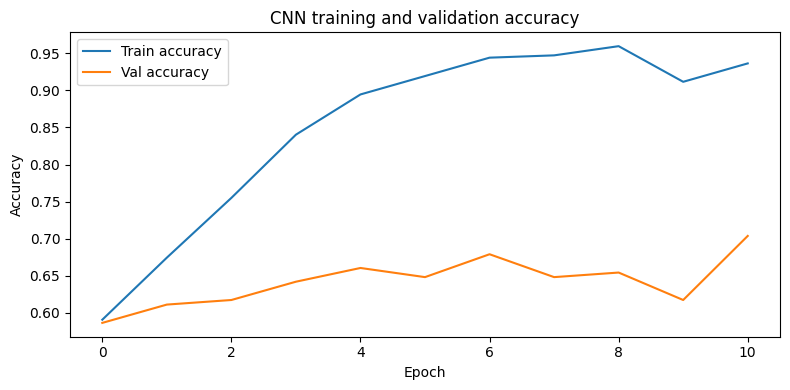

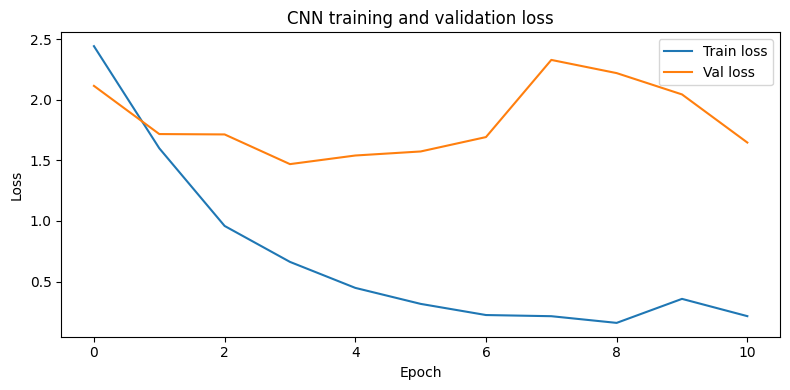

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN training and validation accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN training and validation loss")
plt.legend()
plt.tight_layout()
plt.show()



In [33]:
# Find epoch with best validation accuracy
val_acc = history.history["val_accuracy"]
best_epoch = np.argmax(val_acc) + 1  # +1 because epochs are 1-indexed
best_val_acc = val_acc[best_epoch - 1]

print(f"Best val accuracy at epoch {best_epoch}: {best_val_acc:.4f}")


Best val accuracy at epoch 11: 0.7037


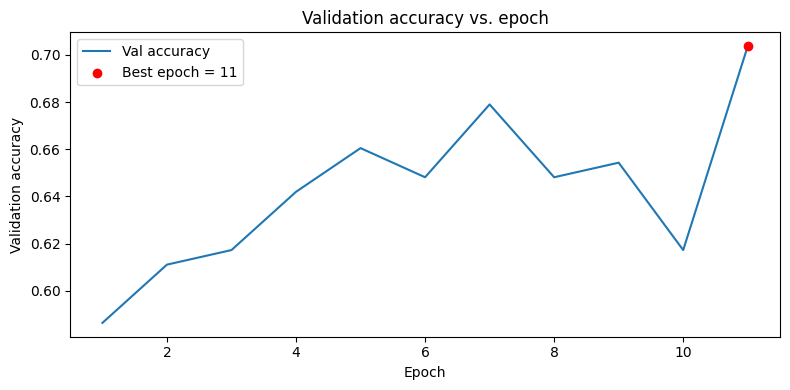

In [36]:
# Plot validation accuracy with best epoch highlighted
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Val accuracy")
plt.scatter(best_epoch, best_val_acc, color="red", zorder=5,
            label=f"Best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy vs. epoch")
plt.legend()
plt.tight_layout()
plt.show()
